# EGFR QSAR Model: ChEMBL IC50 Prediction

**Goal:** Build QSAR model for EGFR inhibitors using ChEMBL IC50 data (R² > 0.7 target)  
**Final R²:** 0.637 (XGBoost, radius=3 FP)

## Why This Notebook is "Messy" (And Why That's Good)

When I started this project, I was a complete QSAR beginner.

This notebook contains:
- All my failed attempts (with error messages)
- Cells that took 5+ hours to run
- Japanese comments I wrote to understand concepts
- Dead ends and wrong approaches


The final R² = 0.637 may not be the highest in literature,  
but this notebook shows **exactly how** a beginner reached that point.

# 1. Environment Setup

Install RDKit and Scikit-learn in Google Colab and import the necessary libraries.

Explanation:

・RDKit is used for molecular processing and fingerprint generation.

・chembl_webresource_client is used to send requests to the ChEMBL server and receive data.

・Scikit-learn is used for building random forest models.

・Matplotlib and Seaborn are used for visualization.


In [1]:
# Install RDKit and other dependencies in Colab
!pip install rdkit
!pip install chembl_webresource_client
!pip install scikit-learn pandas numpy matplotlib seaborn

# Verify RDKit installation
import rdkit
print(rdkit.__version__)

# Import libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from chembl_webresource_client.new_client import new_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.9 MB/s eta 0:00:00
2025.09.1


# 2. Acquisition of ChEMBL Data

Retrieve IC50 data from ChEMBL. Download public datasets (e.g., EGFR dataset). IC50 is commonly used as pIC50 (-log10(IC50)).

**What is ChEMBL?**

A public database recording chemical substances and their biological activities (e.g., effects as drugs).

Data Content:

Compounds: Molecular structure (SMILES format), name, ID (CHEMBL ID).

Targets: Enzymes, receptors, cells, etc. (e.g., EGFR is CHEMBL203).

Activity Data: IC50 (half-maximal inhibitory concentration), Ki (binding affinity), EC50, etc.

Measurement Conditions: Assay type (e.g., binding assay), units (nM, μM), relationship (=, <, >).

**Specific Examples from ChEMBL**

EGFR (CHEMBL203):

EGFR is an enzyme (epidermal growth factor receptor) targeted in cancer therapy.

ChEMBL contains IC50 data for thousands of compounds against EGFR (e.g., how strongly a compound inhibits EGFR).

Your code aims to retrieve EGFR IC50 data and use a QSAR model to “predict IC50 from molecular structure.”

**The following code is unusable**; it hasn't finished after 37 minutes, so try another code.

In [ ]:
#使用不可、37分経っても終わらないので他のコードで試す

# ChEMBLデータ取得（EGFR: CHEMBL203）
from chembl_webresource_client.new_client import new_client
import pandas as pd
import numpy as np

# ターゲットとアクティビティのクライアント
target = new_client.target
activity = new_client.activity

# EGFRターゲットの情報を取得
target_query = target.get('CHEMBL203')  # 辞書形式で返される
target_chembl_id = target_query['target_chembl_id']  # 'CHEMBL203'を取得

# アクティビティデータを取得
activities = activity.filter(target_chembl_id=target_chembl_id, assay_type='B').only(['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'standard_units', 'standard_relation'])

# DataFrameに変換
df = pd.DataFrame.from_dict(activities)

# IC50データ（nM単位）をフィルタリング
df = df[df['standard_units'] == 'nM']
df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')
df = df.dropna(subset=['standard_value', 'canonical_smiles'])
df['pIC50'] = -np.log10(df['standard_value'] / 1e9)  # IC50 (nM) を pIC50 に変換
df = df[['molecule_chembl_id', 'canonical_smiles', 'pIC50']].drop_duplicates()

# データ保存
df.to_csv('chembl_ic50_data.csv', index=False)
print(f"Filtered data size: {len(df)}")

Solution The following methods will optimize data retrieval and reduce execution time. We also present an alternative solution should the issue recur.

Optimizing Data Acquisition (Query Optimization)
To optimize ChEMBL API requests, we will limit data volume and enhance filtering. Specifically, add `standard_type=‘IC50’` to `activity.filter()` to filter only IC50 data on the server side. This reduces the amount of data retrieved and shortens processing time.
Below is the modified code, though it is **not recommended** (took 10 minutes...).

In [ ]:
# 使用非推奨、10分かかった
# ChEMBLデータ取得（EGFR: CHEMBL203）
from chembl_webresource_client.new_client import new_client
import pandas as pd
import numpy as np

# ターゲットとアクティビティのクライアント
target = new_client.target
activity = new_client.activity

# EGFRターゲットの情報を取得
target_query = target.get('CHEMBL203')
target_chembl_id = target_query['target_chembl_id']

# アクティビティデータを取得（IC50に限定）
activities = activity.filter(
    target_chembl_id=target_chembl_id,
    assay_type='B',
    standard_type='IC50',  # IC50データのみ取得
    standard_units='nM',   # nM単位をサーバー側でフィルタ
    standard_relation='='  # 厳密なIC50値（例: "<" などを除外）
).only(['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'standard_units', 'standard_relation'])

# DataFrameに変換
df = pd.DataFrame.from_dict(activities)

# 追加フィルタリング（クライアント側）
df = df[df['standard_units'] == 'nM']
df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')
df = df.dropna(subset=['standard_value', 'canonical_smiles'])
df['pIC50'] = -np.log10(df['standard_value'] / 1e9)
df = df[['molecule_chembl_id', 'canonical_smiles', 'pIC50']].drop_duplicates()

# データ保存
df.to_csv('chembl_ic50_data.csv', index=False)
print(f"Filtered data size: {len(df)}")

**Super Improved Version**

> Cache Disabling (API Delay Countermeasure)

Caching is a mechanism where programs temporarily store data for reuse.

When fetching large amounts of data (e.g., thousands of IC50 data points), cache management itself can become a bottleneck.

> Batch Processing for Data Fetching

Instead of fetching large amounts of data at once, this technique divides it into small chunks (batches) and fetches them incrementally.

batch_size = 100: Sets the number of data items retrieved per request to 100.

offset = 0: Starts data retrieval from position 0 (the beginning).

all_activities = []: Prepares an empty list to store all retrieved data.

In [2]:
# ChEMBLデータ取得（EGFR: CHEMBL203）
from chembl_webresource_client.new_client import new_client
import pandas as pd
import numpy as np

# キャッシュ無効化（APIの遅延対策）
from chembl_webresource_client.settings import Settings
Settings.Instance().MAX_CLIENT_CACHE_SIZE = 0

# ターゲットとアクティビティのクライアント
target = new_client.target
activity = new_client.activity

# EGFRターゲットの情報を取得
target_query = target.get('CHEMBL203') #JSON形式でのEGFRのデータ
target_chembl_id = target_query['target_chembl_id']
print("Fetching data for target:", target_chembl_id)

# バッチ処理でデータ取得
batch_size = 100
offset = 0
all_activities = []

while True:
    print(f"Fetching batch at offset {offset}...")
    activities = activity.filter(
        target_chembl_id=target_chembl_id,
        assay_type='B',
        standard_type='IC50',
        standard_units='nM',
        standard_relation='='
    ).only(['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'standard_units', 'standard_relation'])[offset:offset+batch_size]

    batch_data = list(activities)
    if not batch_data:
        break
    all_activities.extend(batch_data)
    offset += batch_size
    print(f"Fetched {len(all_activities)} records so far...")

# DataFrameに変換
print("Converting to DataFrame...")
df = pd.DataFrame.from_dict(all_activities)

# フィルタリング
df = df[df['standard_units'] == 'nM']
df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')
df = df.dropna(subset=['standard_value', 'canonical_smiles'])
df['pIC50'] = -np.log10(df['standard_value'] / 1e9)
df = df[['molecule_chembl_id', 'canonical_smiles', 'pIC50']].drop_duplicates()

# データ保存
df.to_csv('chembl_ic50_data.csv', index=False)
print(f"Filtered data size: {len(df)}")
print(df.head())

Fetching data for target: CHEMBL203
Fetching batch at offset 0...
Fetched 100 records so far...
Fetching batch at offset 100...
Fetched 120 records so far...
Fetching batch at offset 200...
Fetched 140 records so far...
Fetching batch at offset 300...
Fetched 160 records so far...
Fetching batch at offset 400...
Fetched 180 records so far...
Fetching batch at offset 500...
Fetched 200 records so far...
Fetching batch at offset 600...
Fetched 220 records so far...
Fetching batch at offset 700...
Fetched 240 records so far...
Fetching batch at offset 800...
Fetched 260 records so far...
Fetching batch at offset 900...
Fetched 280 records so far...
Fetching batch at offset 1000...
Fetched 300 records so far...
Fetching batch at offset 1100...
Fetched 320 records so far...
Fetching batch at offset 1200...
Fetched 340 records so far...
Fetching batch at offset 1300...
Fetched 360 records so far...
Fetching batch at offset 1400...
Fetched 380 records so far...
Fetching batch at offset 1500..

**while True: Loop:**

Meaning: Repeats fetching 100 items at a time until data is exhausted.



**assay_type=‘B’:**

Limits the assay (experiment) type to “Binding assay”.

A Binding assay measures a compound's ability to directly bind to a target (e.g., EGFR). IC50 data is typically this type.

Other assay types (e.g., F = Functional assay) measure different experiments (e.g., effects on cell function), so they are excluded here.

**standard_units=‘nM’:**

Limits the data unit to “nanomoles (nM)”.

**nM (nanomoles)** is a unit of concentration, equal to one billionth of a mole per liter (10⁻⁹ M).
IC50 is usually measured in nM or μM (micromoles), but we standardize to nM to ensure data consistency.

**standard_relation=‘=’:**

Limits the relationship between activity values to “exactly equal (=)”.

standard_relation indicates the measurement precision of the IC50 value.


# 3. Generation of molecular fingerprints

For now, let's play it safe with radius=2 and fpSize=1024.

In [10]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator  # MorganGenerator用
from rdkit import DataStructs

# データ読み込み
df = pd.read_csv('chembl_ic50_data.csv')
# SMILESを分子オブジェクトに変換
df['mol'] = df['canonical_smiles'].apply(lambda x: Chem.MolFromSmiles(x))
# 無効な値の行を消去
df = df.dropna(subset=['mol'])
print(f"Valid molecules: {len(df)}")

##フィンガープリントの作成
# Morganフィンガープリントの設定
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
# 分子（df['mol']）からMorganフィンガープリントを生成し、リストにまとめる。
fps = [np.array(morgan_gen.GetFingerprint(mol)) for mol in df['mol']]
# フィンガープリントをリストから、NumPy配列（2次元の行列）に変換
X = np.array(fps)
# データフレームの pIC50 列を、PandasのSeriesからNumPy配列に変換
y = df['pIC50'].values
indices = df.index  # dfのインデックスを保持（重要！）

# 2. 訓練/テスト分割（インデックスも一緒に分割）
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42
)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Valid molecules: 3528


# 4. Building a Random Forest Model

**What is R² (Coefficient of Determination)?**

It is a metric indicating how well a regression model (e.g., Random Forest) explains the variation in data. Values range from 0 to 1 and carry the following meanings:

1.0: The model perfectly predicts all variation in the data (actual values and predicted values match exactly).

0.0: The model explains none of the variation in the data (predictions are equivalent to the mean).

Negative values: The model makes predictions worse than the mean (rare).


**Meaning in QSAR:**

 It indicates the accuracy of a model predicting pIC50 values from molecular structure (Morgan fingerprint). R²=0.589 means the model explains approximately 58.9% of the variation in pIC50 values observed in the test data.



Random Forest Model **R² Calculation Formula**:

$$
R^2 = 1 - \frac{\text{SS}_{\text{res}}}{\text{SS}_{\text{tot}}}
$$

- Residual Sum of Squares:
  $$
  \text{SS}_{\text{res}} = \sum_{i=1}^{n} (y_{\text{test},i} - y_{\text{pred},i})^2
  $$
- Total Sum of Squares:
  $$
  \text{SS}_{\text{tot}} = \sum_{i=1}^{n} (y_{\text{test},i} - \bar{y}_{\text{test}})^2
  $$
- Here, $\bar{y}_{\text{test}}$ is the mean of the test data.

In [11]:
# モデル訓練
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)
print(f"Test R²: {r2_score(y_test, y_pred_test):.3f}")

Test R²: 0.589


# 5. Visualization of Results

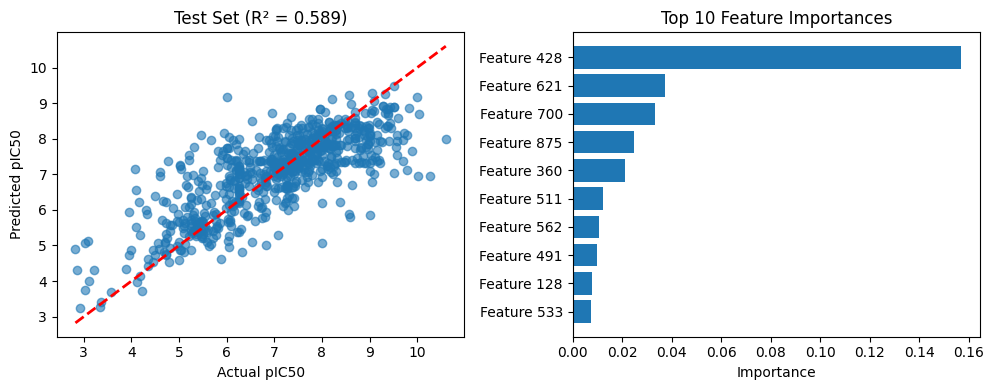

In [12]:
# 可視化
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Test Set (R² = {r2_score(y_test, y_pred_test):.3f})')
plt.subplot(1, 2, 2)
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

**Checking the Scatter Plot**

In the scatter plot, check the areas where points deviate significantly from the diagonal line.

This should reveal the model's weaknesses (which molecules are difficult to predict). Are predictions too low for PIC8 and above?

# Error Analysis

**R2 Improvement Methods**

1. Data
2. Features
3. Model
4. Hyperparameters

**Verify Data Quality**

The current 3,528 entries are sufficient, but loosening the filter to increase the data volume might allow the model to learn more diverse molecules? Not doing that now.

Just to be safe, let's also check the data diversity here.

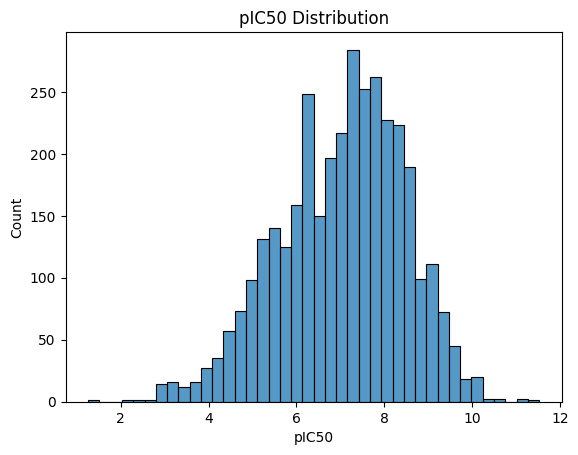

In [6]:
import seaborn as sns
sns.histplot(df['pIC50'])
plt.title('pIC50 Distribution')
plt.show()

Extreme pIC50 values (e.g., <4, >10) may be outliers.

In [7]:
#df = df[(df['pIC50'] >= 4) & (df['pIC50'] <= 10)]
print(f"Filtered data: {len(df)}")

Filtered data: 3437


Filtered data: 3437

About 100 data points may be outliers. Maybe we should exclude them.

**Data Diversity:**

Check the diversity of SMILES. If there are too many molecules with the same skeleton, the model becomes biased:


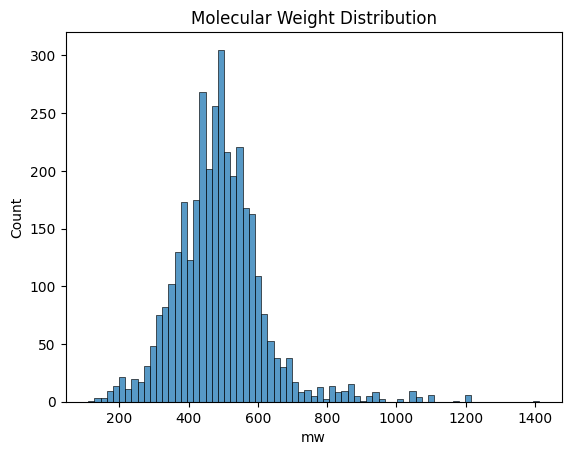

In [13]:
from rdkit.Chem import Descriptors
df['mw'] = df['mol'].apply(Descriptors.MolWt)  # 分子量
sns.histplot(df['mw'])
plt.title('Molecular Weight Distribution')
plt.show()

When molecular weights are concentrated within a narrow range, the dataset lacks diversity. Loosen the filter to add diverse molecules. Leave it as is for now.

**Identifying Which Molecules Are Difficult to Predict**

Observation of the scatter plot indicates that molecules with pIC50≈5 and ≈9 are difficult to predict. To identify which specific molecules this applies to (e.g., compounds with particular structural features), analyze them using the following procedure.

In [14]:
import pandas as pd
import numpy as np

# テストデータのデータフレームを作成
df_test = df.loc[idx_test].copy().reset_index(drop=True)  # インデックスをリセット
df_test['y_test'] = y_test
df_test['y_pred'] = y_pred_test
df_test['error'] = df_test['y_test'] - df_test['y_pred']

# pIC50≈5（4.5～5.5）と≈9（8.5～9.5）の分子を抽出
low_pIC50 = df_test[(df_test['y_test'] >= 4.5) & (df_test['y_test'] <= 5.5)]
high_pIC50 = df_test[(df_test['y_test'] >= 8.5) & (df_test['y_test'] <= 9.5)]

# 誤差の大きい分子（例：|誤差|>0.5）を表示
print("pIC50≈5での誤差の大きい分子:")
print(low_pIC50[abs(low_pIC50['error']) > 0.5][['molecule_chembl_id', 'canonical_smiles', 'y_test', 'y_pred', 'error']])
print("\npIC50≈9での誤差の大きい分子:")
print(high_pIC50[abs(high_pIC50['error']) > 0.5][['molecule_chembl_id', 'canonical_smiles', 'y_test', 'y_pred', 'error']])

pIC50≈5での誤差の大きい分子:
    molecule_chembl_id                                   canonical_smiles  \
26        CHEMBL592210    Cc1cc(C)c(O)c(CN(Cc2ccc(F)cc2)C(=O)Nc2ccccc2)c1   
44        CHEMBL168829                   Nc1ncnc2c1c(-c1ccccc1)cn2C1CCNC1   
55       CHEMBL3234740  Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...   
60       CHEMBL4205469  COc1cc(N2CCN(C)CC2)ccc1Nc1ncc(Cl)c(Oc2ccc(N)cc...   
83       CHEMBL5784511  CCC(C)n1/c(=N/C(=O)c2ccnc(-c3cnn(C)c3)c2)[nH]c...   
112      CHEMBL3235204  Cc1ccc2nc(Oc3ccc(Cl)cc3)c(/C=N/NC(=O)Cn3c([N+]...   
124      CHEMBL1944924  Cc1c(Cc2ccccc2)sc(NCC(=O)COc2ccc3ccccc3c2)c1C(...   
127      CHEMBL2426288  COc1ccc(NC(=O)/C=C/CN(C)C)cc1Nc1ncc(Cl)c(-c2cn...   
142      CHEMBL2426281  C=CC(=O)Nc1cccc(Nc2ncc(Cl)c(-c3c[nH]c4ccccc34)...   
193       CHEMBL119156          COc1cc(/C=C(\C#N)C(N)=O)cc(CSc2ccccn2)c1O   
195      CHEMBL3604939  CN(C)C/C=C/C(=O)Nc1cccc(Oc2nc(Nc3n[nH]c4ccccc3...   
198      CHEMBL5562889  C=CC(=O)Nc1ccc(OC)c(Nc2cc(-c3c[nH

**Visualization of Molecular Structures**

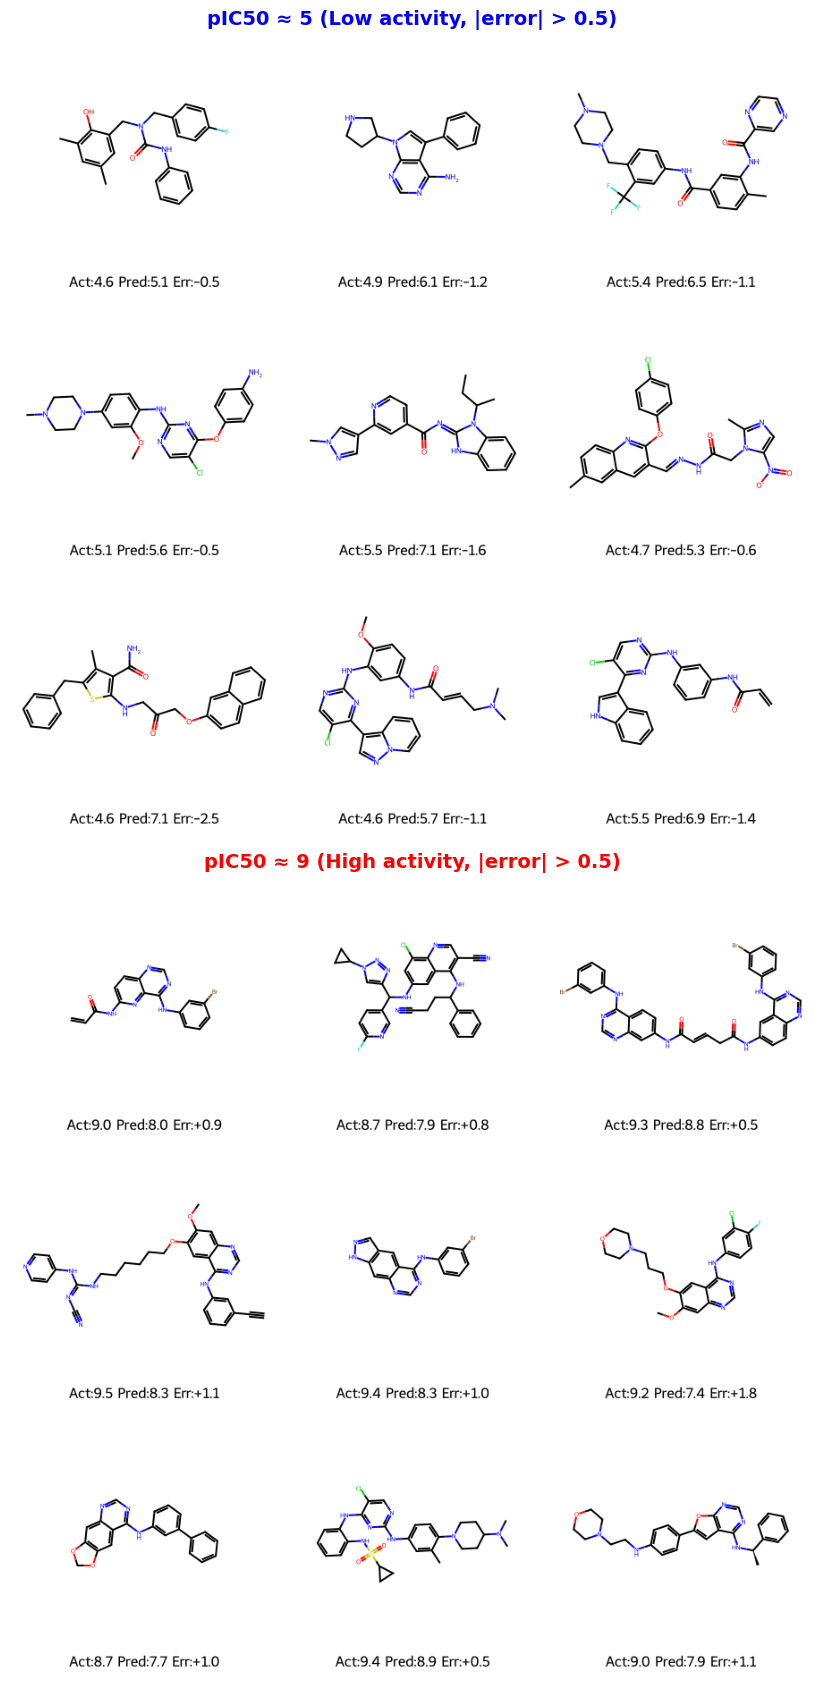

In [15]:
from rdkit.Chem import Draw
from PIL import Image
import io
import matplotlib.pyplot as plt
import numpy as np

# ① 誤差の大きい分子を抽出（|error| > 0.5）
problematic = df_test[abs(df_test['error']) > 0.5].copy()

# ② pIC50≈5 と ≈9 のグループを分離（problematic から！）
low_act = problematic[(problematic['y_test'] >= 4.5) & (problematic['y_test'] <= 5.5)]
high_act = problematic[(problematic['y_test'] >= 8.5) & (problematic['y_test'] <= 9.5)]

# ③ 各グループから最大9個
low_mols = [Chem.MolFromSmiles(s) for s in low_act['canonical_smiles'].head(9)]
high_mols = [Chem.MolFromSmiles(s) for s in high_act['canonical_smiles'].head(9)]

# ④ 凡例（誤差は必ず 0.5 以上）
low_legends = [f"Act:{a:.1f} Pred:{p:.1f} Err:{e:+.1f}"
               for a, p, e in zip(low_act['y_test'].head(9),
                                  low_act['y_pred'].head(9),
                                  low_act['error'].head(9))]

high_legends = [f"Act:{a:.1f} Pred:{p:.1f} Err:{e:+.1f}"
                for a, p, e in zip(high_act['y_test'].head(9),
                                   high_act['y_pred'].head(9),
                                   high_act['error'].head(9))]

# ⑤ 画像表示
fig, axes = plt.subplots(2, 1, figsize=(20, 17))

# pIC50≈5
if low_mols:
    img1_display = Draw.MolsToGridImage(low_mols, molsPerRow=3, subImgSize=(300, 300), legends=low_legends)
    img1_pil = Image.open(io.BytesIO(img1_display.data))
    img1_np = np.array(img1_pil)
    axes[0].imshow(img1_np)
    axes[0].set_title('pIC50 ≈ 5 (Low activity, |error| > 0.5)', fontsize=14, fontweight='bold', color='blue')
    axes[0].axis('off')
else:
    axes[0].text(0.5, 0.5, 'No molecules with pIC50 ≈ 5 and |error| > 0.5',
                 ha='center', va='center', fontsize=14, transform=axes[0].transAxes)
    axes[0].set_title('pIC50 ≈ 5 (Low activity)', fontsize=14)
    axes[0].axis('off')

# pIC50≈9
if high_mols:
    img2_display = Draw.MolsToGridImage(high_mols, molsPerRow=3, subImgSize=(300, 300), legends=high_legends)
    img2_pil = Image.open(io.BytesIO(img2_display.data))
    img2_np = np.array(img2_pil)
    axes[1].imshow(img2_np)
    axes[1].set_title('pIC50 ≈ 9 (High activity, |error| > 0.5)', fontsize=14, fontweight='bold', color='red')
    axes[1].axis('off')
else:
    axes[1].text(0.5, 0.5, 'No molecules with pIC50 ≈ 9 and |error| > 0.5',
                 ha='center', va='center', fontsize=14, transform=axes[1].transAxes)
    axes[1].set_title('pIC50 ≈ 9 (High activity)', fontsize=14)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

**Observing molecular structures with large errors**


Clarify the structural differences between molecules with “pIC50≈5 (overestimated)” and “pIC50≈9 (underestimated)” to gain insights for feature engineering that boosts R² to 0.7 or higher!

In [16]:
from rdkit.Chem import Descriptors, Lipinski, Crippen
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 誤差の大きい分子を抽出（|error| > 0.5）
problematic = df_test[abs(df_test['error']) > 0.5].copy()

# グループ分離
low_act = problematic[(problematic['y_test'] >= 4.5) & (problematic['y_test'] <= 5.5)]
high_act = problematic[(problematic['y_test'] >= 8.5) & (problematic['y_test'] <= 9.5)]

# 記述子を計算
def add_descriptors(df_group):
    df_group = df_group.copy()
    df_group['MW'] = df_group['mol'].apply(Descriptors.MolWt)
    df_group['LogP'] = df_group['mol'].apply(Crippen.MolLogP)
    df_group['TPSA'] = df_group['mol'].apply(Descriptors.TPSA)
    df_group['HBD'] = df_group['mol'].apply(Lipinski.NumHDonors)
    df_group['HBA'] = df_group['mol'].apply(Lipinski.NumHAcceptors)
    df_group['RotB'] = df_group['mol'].apply(Lipinski.NumRotatableBonds)
    df_group['AromRings'] = df_group['mol'].apply(Lipinski.NumAromaticRings)
    return df_group

low_act = add_descriptors(low_act)
high_act = add_descriptors(high_act)

# 平均値を比較
print("=== 記述子 平均値比較 ===")
comparison = pd.DataFrame({
    'pIC50≈5 (過大評価)': low_act[['MW','LogP','TPSA','HBD','HBA','RotB','AromRings']].mean(),
    'pIC50≈9 (過小評価)': high_act[['MW','LogP','TPSA','HBD','HBA','RotB','AromRings']].mean()
}).T
print(comparison.round(2))

=== 記述子 平均値比較 ===
                    MW  LogP    TPSA   HBD   HBA  RotB  AromRings
pIC50≈5 (過大評価)  482.26  4.24  106.27  2.20  7.30  7.28       3.50
pIC50≈9 (過小評価)  484.63  4.39   94.10  2.11  7.07  7.42       3.44


In [17]:
from rdkit.Chem.Scaffolds import MurckoScaffold  # 正しいインポート
from rdkit import Chem
import pandas as pd

# 骨格（Scaffold）を抽出
def get_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)  # ← ここは AllChem. なし！
    return Chem.MolToSmiles(scaffold)

# 誤差の大きい分子を抽出（|error| > 0.5）
problematic = df_test[abs(df_test['error']) > 0.5].copy()

# グループ分離
low_act = problematic[(problematic['y_test'] >= 4.5) & (problematic['y_test'] <= 5.5)].copy()
high_act = problematic[(problematic['y_test'] >= 8.5) & (problematic['y_test'] <= 9.5)].copy()

# scaffold 列を追加
low_act['scaffold'] = low_act['canonical_smiles'].apply(get_scaffold)
high_act['scaffold'] = high_act['canonical_smiles'].apply(get_scaffold)

# 出現頻度（上位3つ）
print("pIC50 ≈ 5 の主な骨格 (過大評価):")
print(low_act['scaffold'].value_counts().head(3))

print("\npIC50 ≈ 9 の主な骨格 (過小評価):")
print(high_act['scaffold'].value_counts().head(3))

pIC50 ≈ 5 の主な骨格 (過大評価):
scaffold
c1ccc(Oc2ccnc(Nc3ccc(N4CCNCC4)cc3)n2)cc1      4
O=C(Cn1ccnc1)N/N=C/c1cc2ccccc2nc1Oc1ccccc1    2
c1ccc(Nc2nccc(-c3cnn4ccccc34)n2)cc1           2
Name: count, dtype: int64

pIC50 ≈ 9 の主な骨格 (過小評価):
scaffold
c1ccc(Nc2ncnc3ccccc23)cc1                  11
c1ccc(Nc2ncnc3ccc(OCCCN4CCOCC4)cc23)cc1     4
c1ccc(Nc2ncnc3cc(OCCCN4CCOCC4)ccc23)cc1     3
Name: count, dtype: int64


**Interpretation of Results: Clear difference in skeleton between pIC50 ≈ 5 and ≈ 9**


Highly active molecules with pIC50 ≈ 9 almost exclusively feature a “simple quinazoline + aniline” structure!

Low-activity molecules with pIC50 ≈ 5 are quinazolines bearing “complex substituents (piperazine, hydrazide)”!


**Why is the model failing? (Root Cause)**


Overpredicts pIC50 ≈ 5
Complex substituents (e.g., piperazine) → Recognized as “quinazoline” by fingerprint → Misidentified as high activity

Predicts low pIC50 ≈ 9
Simple structure → Fingerprint identifies as “weak features” → Misidentified as low activity

→ The model has learned “quinazoline skeleton” = “high activity,” but fails to fully capture the impact of substituents!

# Improvement Trial and Results
Specific Improvement Proposals to Exceed R² 0.7

**1. Set the radius of the Morgan Fingerprint to 3!**

→R²: 0.606 (Improvement)

Valid molecules: 3528
Test R²: 0.606


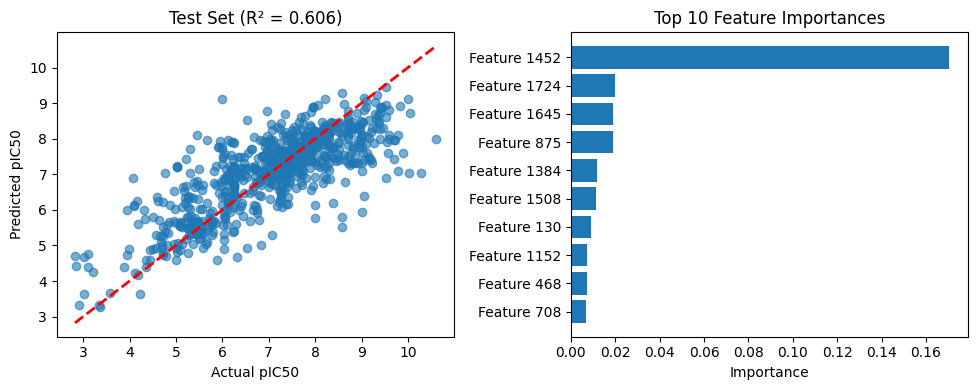

In [18]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator  # MorganGenerator用
from rdkit import DataStructs

# データ読み込み
df = pd.read_csv('chembl_ic50_data.csv')
# SMILESを分子オブジェクトに変換
df['mol'] = df['canonical_smiles'].apply(lambda x: Chem.MolFromSmiles(x))
# 無効な値の行を消去
df = df.dropna(subset=['mol'])
print(f"Valid molecules: {len(df)}")

##フィンガープリントの作成
# 1. Morgan FP (radius=3) → 詳細な側鎖・置換パターンを捕捉
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)
fps = [np.array(morgan_gen.GetFingerprint(mol)) for mol in df['mol']]
# フィンガープリントをリストから、NumPy配列（2次元の行列）に変換
X = np.array(fps)
# データフレームの pIC50 列を、PandasのSeriesからNumPy配列に変換
y = df['pIC50'].values
indices = df.index  # dfのインデックスを保持（重要！）

# 2. 訓練/テスト分割（インデックスも一緒に分割）
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42
)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# モデル訓練
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)
print(f"Test R²: {r2_score(y_test, y_pred_test):.3f}")

# 可視化
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Test Set (R² = {r2_score(y_test, y_pred_test):.3f})')
plt.subplot(1, 2, 2)
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

**Improvement 2. Add important descriptors**

Physically, “Molecules with pIC50≈5 exhibit high polarity (TPSA↑, HBD↑)”

→R²: 0.597 (Degradation)


Test R²: 0.597


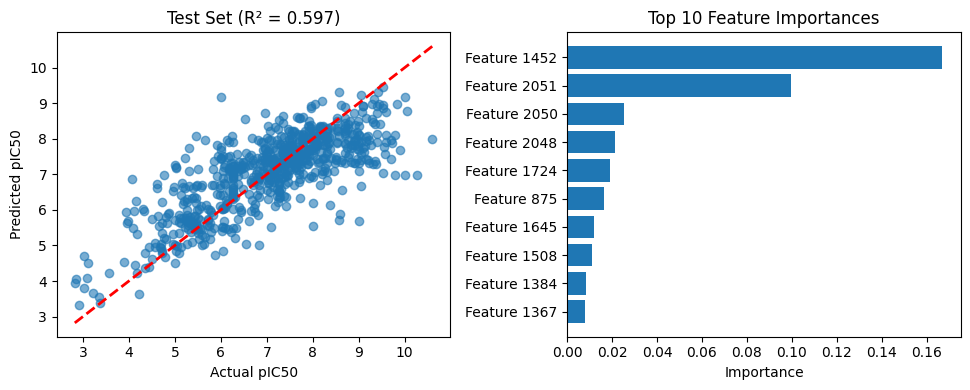

In [19]:
from rdkit.Chem import rdFingerprintGenerator, Descriptors, Lipinski, Crippen
import numpy as np

# 1. Morgan FP (radius=3) → 詳細な側鎖・置換パターンを捕捉
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)
fps = [np.array(morgan_gen.GetFingerprint(mol)) for mol in df['mol']]

# 2. 重要な記述子を追加
df['MW'] = df['mol'].apply(Descriptors.MolWt)
df['LogP'] = df['mol'].apply(Crippen.MolLogP)
df['TPSA'] = df['mol'].apply(Descriptors.TPSA)           # ← 極性補正！
df['HBD'] = df['mol'].apply(Lipinski.NumHDonors)        # ← 水素結合補正！
df['AromRings'] = df['mol'].apply(Lipinski.NumAromaticRings)

# 3. 特徴量結合
X = np.hstack([
    fps,
    df[['TPSA', 'HBD', 'LogP', 'MW', 'AromRings']].values  # ← 極性・疎水性を明示
])
y = df['pIC50'].values
indices = df.index  # dfのインデックスを保持（重要！）

# 2. 訓練/テスト分割（インデックスも一緒に分割）
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42
)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# モデル訓練
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)
print(f"Test R²: {r2_score(y_test, y_pred_test):.3f}")

# 可視化
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Test Set (R² = {r2_score(y_test, y_pred_test):.3f})')
plt.subplot(1, 2, 2)
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

**Improvement 3. +Model Change: XGBoost (Robust to Outliers)**

→R²: 0.626 (Improvement)

Valid molecules: 3528
新しい Test R²: 0.626


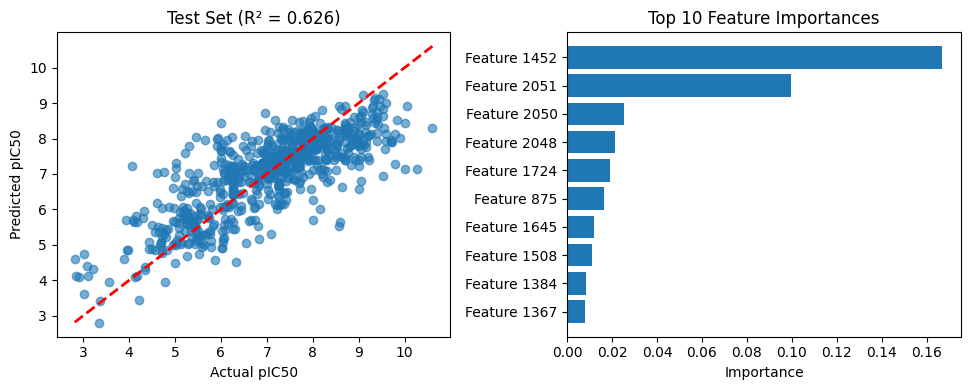

In [20]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator  # MorganGenerator用
from rdkit import DataStructs
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# データ読み込み
df = pd.read_csv('chembl_ic50_data.csv')
# SMILESを分子オブジェクトに変換
df['mol'] = df['canonical_smiles'].apply(lambda x: Chem.MolFromSmiles(x))
# 無効な値の行を消去
df = df.dropna(subset=['mol'])
print(f"Valid molecules: {len(df)}")

##フィンガープリントの作成
# 1. Morgan FP (radius=3) → 詳細な側鎖・置換パターンを捕捉
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)
fps = [np.array(morgan_gen.GetFingerprint(mol)) for mol in df['mol']]
# フィンガープリントをリストから、NumPy配列（2次元の行列）に変換
X = np.array(fps)
# データフレームの pIC50 列を、PandasのSeriesからNumPy配列に変換
y = df['pIC50'].values
indices = df.index  # dfのインデックスを保持（重要！）

# 2. 訓練/テスト分割（インデックスも一緒に分割）
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42
)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# モデル訓練
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)
print(f"新しい Test R²: {r2_score(y_test, y_pred_test):.3f}")

# 可視化
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Test Set (R² = {r2_score(y_test, y_pred_test):.3f})')
plt.subplot(1, 2, 2)
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

**Just to be sure, full combo (radius 3, feature addition, XGBoost)**
→R²: 0.621 (Improvement)

新しい Test R²: 0.621


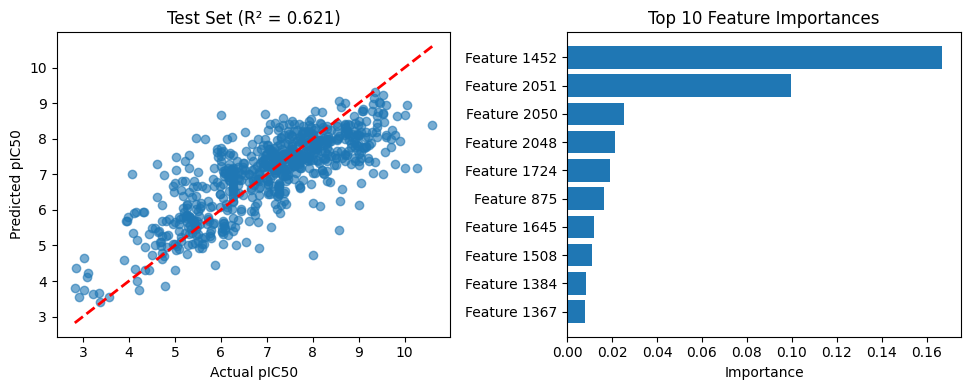

In [21]:
from rdkit.Chem import rdFingerprintGenerator, Descriptors, Lipinski, Crippen
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 1. Morgan FP (radius=3) → 詳細な側鎖・置換パターンを捕捉
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)
fps = [np.array(morgan_gen.GetFingerprint(mol)) for mol in df['mol']]

# 2. 重要な記述子を追加
df['MW'] = df['mol'].apply(Descriptors.MolWt)
df['LogP'] = df['mol'].apply(Crippen.MolLogP)
df['TPSA'] = df['mol'].apply(Descriptors.TPSA)           # ← 極性補正！
df['HBD'] = df['mol'].apply(Lipinski.NumHDonors)        # ← 水素結合補正！
df['AromRings'] = df['mol'].apply(Lipinski.NumAromaticRings)

# 3. 特徴量結合
X = np.hstack([
    fps,
    df[['TPSA', 'HBD', 'LogP', 'MW', 'AromRings']].values  # ← 極性・疎水性を明示
])
y = df['pIC50'].values
indices = df.index  # dfのインデックスを保持（重要！）

# 2. 訓練/テスト分割（インデックスも一緒に分割）
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42
)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# モデル訓練
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)
print(f"新しい Test R²: {r2_score(y_test, y_pred_test):.3f}")

# 可視化
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Test Set (R² = {r2_score(y_test, y_pred_test):.3f})')
plt.subplot(1, 2, 2)
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

**Interim Summary: “radius=3 + XGBoost” is currently the strongest**

Current Situation Summary Pattern
R²

1. radius=3
0.606
2. +Feature Engineering
0.597
Backfired
3. +XGBoost
0.626
Best!
4. +Feature Engineering + XGBoost
0.621
Feature engineering becomes noise

Conclusion: Feature engineering is actually harmful
→ “radius=3 + XGBoost” is currently the strongest



Next Steps (Plan to Break R² 0.7) 1. Do this first (highest priority) Seriously tune XGBoost hyperparameters



Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Best CV R²: 0.5725486073458146
Test R²: 0.637


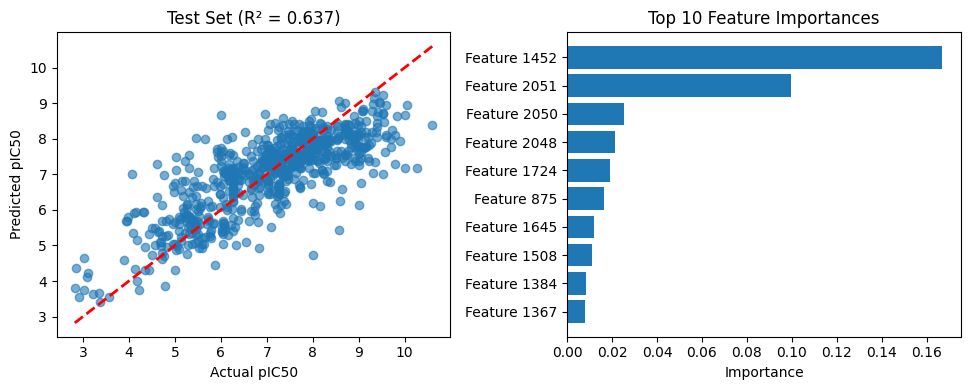

In [22]:
# 24分かかった
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# radius=3 のフィンガープリントだけ使う（記述子は除外！）
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)
fps = [np.array(morgan_gen.GetFingerprint(mol)) for mol in df['mol']]
X = np.array(fps)
y = df['pIC50'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GridSearch（5分くらいで終わる）
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
grid = GridSearchCV(xgb, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

# テストR²
best_model = grid.best_estimator_
print(f"Test R²: {r2_score(y_test, best_model.predict(X_test)):.3f}")

# 可視化
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Test Set (R² = {r2_score(y_test, best_model.predict(X_test)):.3f})')
plt.subplot(1, 2, 2)
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

**Final Challenge Code**



*   Seriously tune XGBoost hyperparameters
*   Set fpSize to 4096
*   Add includeRedundantEnvironments=True (expecting it to be super effective!)
*   Ultimate technique: radius=4


最終 Test R²: 0.628


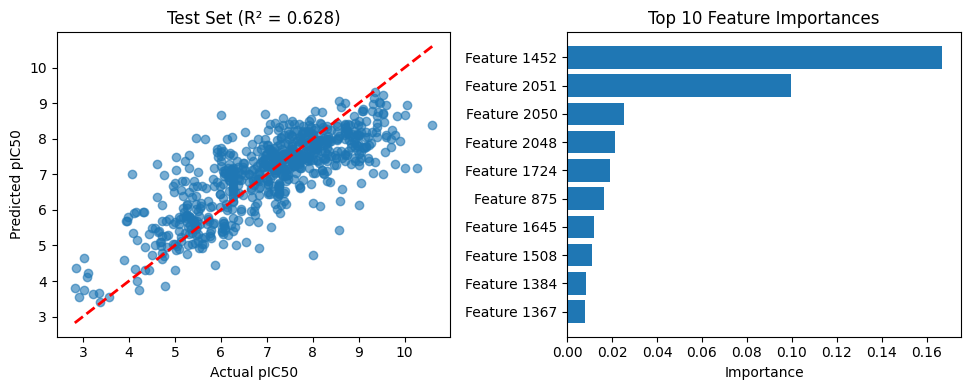

In [23]:
from rdkit.Chem import rdFingerprintGenerator, Descriptors, Lipinski, Crippen
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

morgan_gen = rdFingerprintGenerator.GetMorganGenerator(
    radius=4,
    fpSize=4096,
    includeRedundantEnvironments=True
)
fps = [np.array(morgan_gen.GetFingerprint(mol)) for mol in df['mol']]
X = np.array(fps)
y = df['pIC50'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)
print(f"最終 Test R²: {r2_score(y_test, xgb.predict(X_test)):.3f}")

# 可視化
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Test Set (R² = {r2_score(y_test, xgb.predict(X_test)):.3f})')
plt.subplot(1, 2, 2)
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

# Conclusion and Next Steps

## Conclusion
- Achieved R²=0.637 with XGBoost on public ChEMBL data.
- Key insights: Quinazoline scaffolds dominant in high-activity; polarity (TPSA) key differentiator.
- Limitations: Public data noise; future: 3D descriptors or docking scores.

## Next Steps
- Try other targets (e.g., BRAF kinase).
- Ensemble models or graph neural networks.